In [14]:
import numpy as np
import pandas as pd
import cv2
import os
import random
from skimage import io
from PIL import Image 
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [53]:
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        #zoom_range=0.01,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

In [54]:
yes_image_path = 'C:/Users/anvit/OneDrive/Desktop/Project_1/brain_tumor_dataset/yes'
yes_count = 5
for img in os.listdir(yes_image_path):
    img = cv2.imread(yes_image_path + '\\' + img)
    img = img_to_array(img)
    img = cv2.resize(img, (256, 256))
    img = img.reshape((1,) + img.shape)
    
    i = 0
    for batch in datagen.flow(img, batch_size=1,save_to_dir='C:/Users/anvit/OneDrive/Desktop/Project_1/brain_tumor_dataset/yes_aug', save_prefix='aug_', save_format='jpg'):
        i += 1
        if i > yes_count:
            break  # otherwise the generator would loop indefinitely

In [55]:
no_image_path = 'C:/Users/anvit/OneDrive/Desktop/Project_1/brain_tumor_dataset/no'
no_count = 8
for img in os.listdir(no_image_path):
    img = cv2.imread(no_image_path + '\\' + img)
    img = img_to_array(img)
    img = cv2.resize(img, (256, 256))
    img = img.reshape((1,) + img.shape)
    
    i = 0
    for batch in datagen.flow(img, batch_size=1,save_to_dir='C:/Users/anvit/OneDrive/Desktop/Project_1/brain_tumor_dataset/no_aug', save_prefix='aug_', save_format='jpg'):
        i += 1
        if i > no_count:
            break  # otherwise the generator would loop indefinitely

In [4]:
yes_images = os.listdir('C:/Users/anvit/OneDrive/Desktop/Project_1/brain_tumor_dataset/yes_aug/')
no_images = os.listdir('C:/Users/anvit/OneDrive/Desktop/Project_1/brain_tumor_dataset/no_aug/')
data = np.concatenate([yes_images, no_images])
len(data) == len(yes_images) + len(no_images)

True

In [5]:
target_pos = np.full(len(yes_images), 1)
target_neg = np.full(len(no_images), 0)
target_data = np.concatenate([target_pos, target_neg])
len(target_data)==len(target_pos) + len(target_neg)

True

In [6]:
split_data = []
for image in yes_images:
    img = cv2.imread('C:/Users/anvit/OneDrive/Desktop/Project_1/brain_tumor_dataset/yes_aug/' + image)
    face = cv2.resize(img, (256, 256))
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    split_data.append(face)
    
for image in no_images:
    img = cv2.imread('C:/Users/anvit/OneDrive/Desktop/Project_1/brain_tumor_dataset/no_aug/' + image)
    face = cv2.resize(img, (256, 256))
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    split_data.append(face)

In [7]:
d = np.squeeze(split_data)

In [8]:
d.shape

(1725, 256, 256, 3)

In [9]:
# normalize data
d = d.astype('float32')
d /= 255

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(d, target_data, test_size=0.3,random_state=109) # 70% training and 30% test

In [11]:
X_train.shape, X_test.shape

((1207, 256, 256, 3), (518, 256, 256, 3))

In [85]:
# X_train = X_train.reshape(-1, 256,256, 1)
# X_test = X_test.reshape(-1, 256,256, 1)
# X_train.shape, X_test.shape

In [89]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential

num_filters = 8
filter_size = 3
pool_size = 2

model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(256, 256, 3)),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(1, activation='softmax'),
])

In [90]:
model.compile(
  'adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

In [91]:
model.fit(
  X_train,
  y_train,
  epochs=3,
  validation_data=(X_test, y_test),
)

Train on 1207 samples, validate on 518 samples
Epoch 1/3
1207/1207 [==============================] - 36s 30ms/step - loss: 7.5459 - accuracy: 0.5079 - val_loss: 7.2125 - val_accuracy: 0.5270
Epoch 2/3
1207/1207 [==============================] - 34s 28ms/step - loss: 7.5459 - accuracy: 0.5079 - val_loss: 7.2125 - val_accuracy: 0.5270
Epoch 3/3
1207/1207 [==============================] - 34s 28ms/step - loss: 7.5459 - accuracy: 0.5079 - val_loss: 7.2125 - val_accuracy: 0.5270


In [12]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential

# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution 
# convolution helps us look for specific localized image features - Edges
classifier.add(Conv2D(32, (3, 3), input_shape = (256, 256, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a fourth convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 64, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [96]:
history = classifier.fit(
  X_train,
  y_train,
  epochs=10,
  validation_data=(X_test, y_test),
)

Train on 1207 samples, validate on 518 samples
Epoch 1/10
1207/1207 [==============================] - 133s 110ms/step - loss: 0.3869 - accuracy: 0.8277 - val_loss: 0.4427 - val_accuracy: 0.8185
Epoch 2/10
1207/1207 [==============================] - 133s 110ms/step - loss: 0.3227 - accuracy: 0.8666 - val_loss: 0.4362 - val_accuracy: 0.8436
Epoch 3/10
1207/1207 [==============================] - 121s 100ms/step - loss: 0.2541 - accuracy: 0.9056 - val_loss: 0.4790 - val_accuracy: 0.8340
Epoch 4/10
1207/1207 [==============================] - 119s 99ms/step - loss: 0.2135 - accuracy: 0.9147 - val_loss: 0.6047 - val_accuracy: 0.7973
Epoch 5/10
1207/1207 [==============================] - 122s 101ms/step - loss: 0.1797 - accuracy: 0.9312 - val_loss: 0.5970 - val_accuracy: 0.8243
Epoch 6/10
1207/1207 [==============================] - 149s 123ms/step - loss: 0.1119 - accuracy: 0.9553 - val_loss: 0.6012 - val_accuracy: 0.8185
Epoch 7/10
1207/1207 [==============================] - 145s 120ms

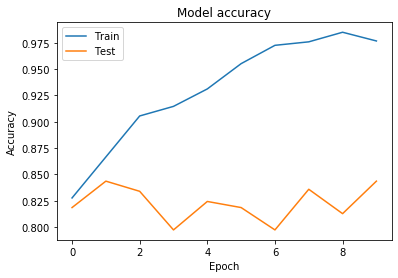

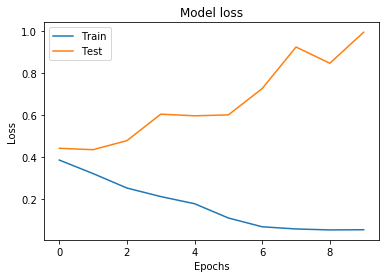

In [98]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Decreasing layers to see if it helps with the overfitting issue

Train on 1207 samples, validate on 518 samples
Epoch 1/10
1207/1207 [==============================] - 69s 57ms/step - loss: 0.6042 - accuracy: 0.6852 - val_loss: 0.4977 - val_accuracy: 0.7896
Epoch 2/10
1207/1207 [==============================] - 52s 43ms/step - loss: 0.4910 - accuracy: 0.7672 - val_loss: 0.6431 - val_accuracy: 0.7124
Epoch 3/10
1207/1207 [==============================] - 53s 44ms/step - loss: 0.4470 - accuracy: 0.7912 - val_loss: 0.5586 - val_accuracy: 0.7703
Epoch 4/10
1207/1207 [==============================] - 53s 44ms/step - loss: 0.3616 - accuracy: 0.8459 - val_loss: 0.4495 - val_accuracy: 0.8031
Epoch 5/10
1207/1207 [==============================] - 52s 43ms/step - loss: 0.3118 - accuracy: 0.8724 - val_loss: 0.4979 - val_accuracy: 0.8147
Epoch 6/10
1207/1207 [==============================] - 52s 43ms/step - loss: 0.2090 - accuracy: 0.9229 - val_loss: 0.5750 - val_accuracy: 0.8012
Epoch 7/10
1207/1207 [==============================] - 52s 43ms/step - loss:

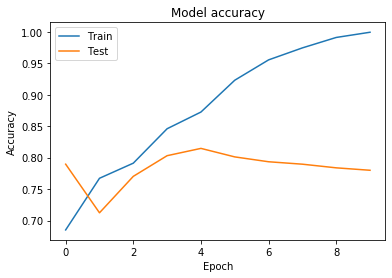

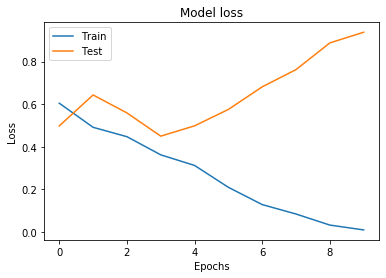

In [103]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution 
# convolution helps us look for specific localized image features - Edges
classifier.add(Conv2D(16, (3, 3), input_shape = (256, 256, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer
classifier.add(Conv2D(48, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))


# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 48, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = classifier.fit(
  X_train,
  y_train,
  epochs=10,
  validation_data=(X_test, y_test),
)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution 
# convolution helps us look for specific localized image features - Edges
classifier.add(Conv2D(32, (3, 3), input_shape = (256, 256, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Dropout
classifier.add(Dropout(0.5))

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.5))

# Adding a third convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.5))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 64, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = classifier.fit(
  X_train,
  y_train,
  epochs=10,
  validation_data=(X_test, y_test),
)


Train on 1207 samples, validate on 518 samples
Epoch 1/10
1207/1207 [==============================] - 131s 109ms/step - loss: 0.9304 - accuracy: 0.5824 - val_loss: 0.6566 - val_accuracy: 0.7104
Epoch 2/10
1207/1207 [==============================] - 123s 102ms/step - loss: 0.6166 - accuracy: 0.6769 - val_loss: 0.5891 - val_accuracy: 0.7220
Epoch 3/10
1207/1207 [==============================] - 123s 102ms/step - loss: 0.5641 - accuracy: 0.7084 - val_loss: 0.5817 - val_accuracy: 0.7548
Epoch 4/10
1207/1207 [==============================] - 128s 106ms/step - loss: 0.5051 - accuracy: 0.7481 - val_loss: 0.5648 - val_accuracy: 0.7625
Epoch 5/10
1207/1207 [==============================] - 123s 102ms/step - loss: 0.4838 - accuracy: 0.7622 - val_loss: 0.5420 - val_accuracy: 0.7741
Epoch 6/10
1207/1207 [==============================] - 125s 103ms/step - loss: 0.4188 - accuracy: 0.8111 - val_loss: 0.5509 - val_accuracy: 0.7413
Epoch 7/10
1207/1207 [==============================] - 123s 102m

NameError: name 'plt' is not defined

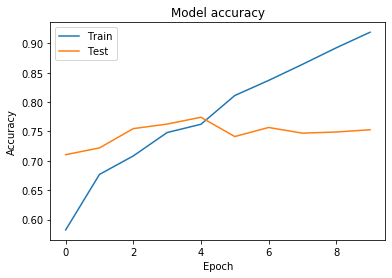

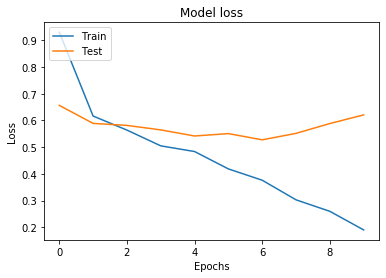

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 128)      

In [17]:
# Evaluate the model on test set
score = classifier.evaluate(X_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.7528957724571228


In [18]:
y_pred = classifier.predict(X_test)

In [19]:
# Import the modules from `sklearn.metrics`
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

# Confusion matrix
confusion_matrix(y_test, y_pred.round())

array([[172,  73],
       [ 55, 218]], dtype=int64)

In [20]:
precision_score(y_test, y_pred.round())

0.7491408934707904

In [21]:
recall_score(y_test, y_pred.round())

0.7985347985347986

In [156]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[10].reshape(1,256,256,3))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index-1], cmap='gray')
            activation_index += 1

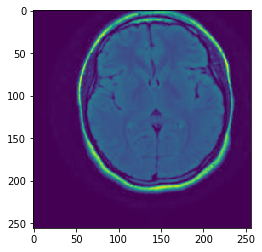

In [157]:
plt.imshow(X_train[10][:,:,0]);

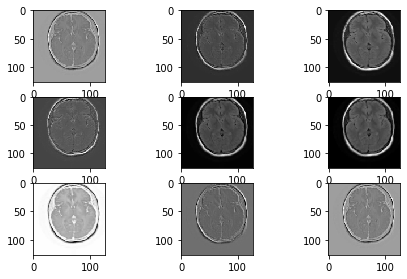

In [158]:
display_activation(activations,3, 3, 1)

conv2d_5_input (1, 256, 256, 3) 


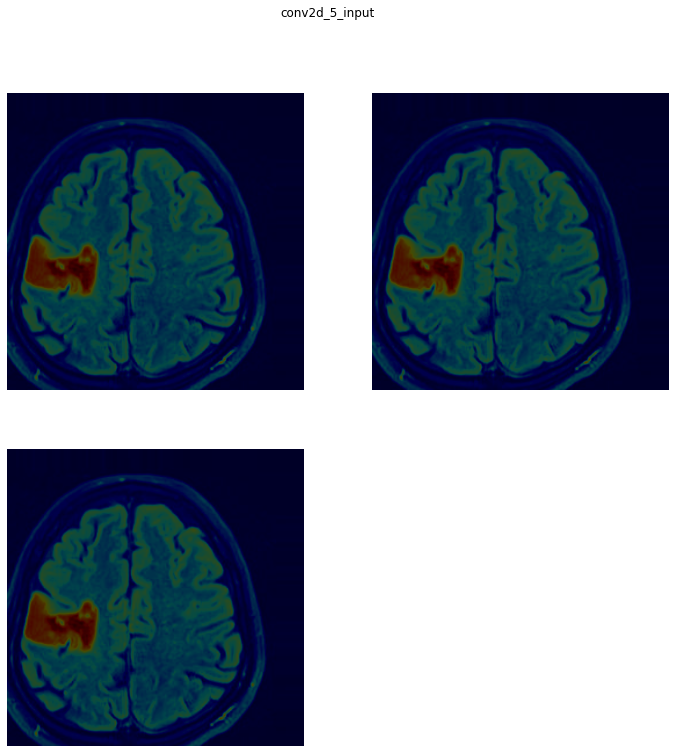

conv2d_5 (1, 254, 254, 32) 


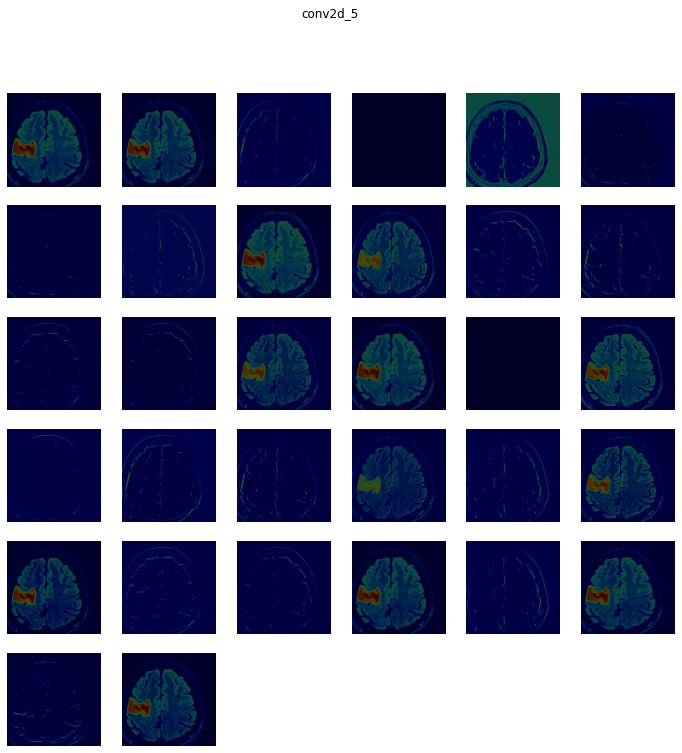

max_pooling2d_5 (1, 127, 127, 32) 


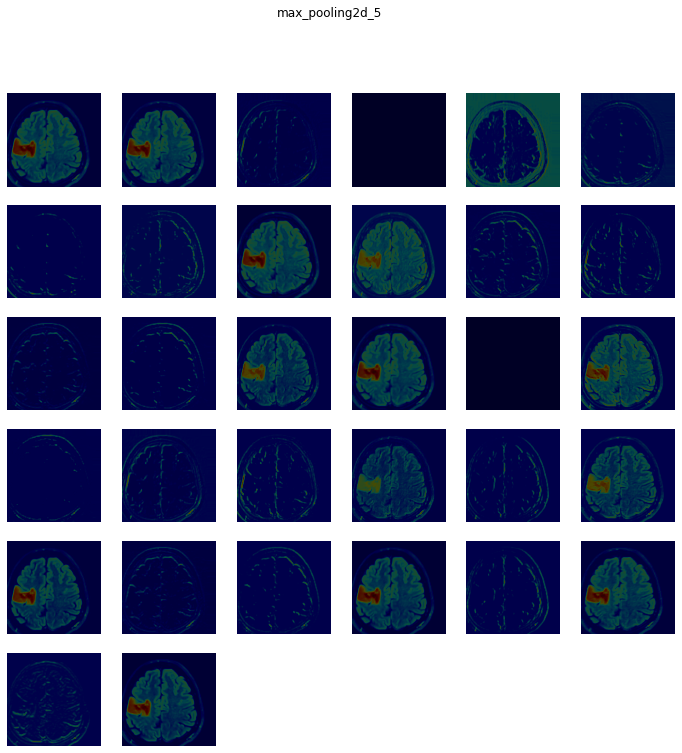

dropout_1 (1, 127, 127, 32) 


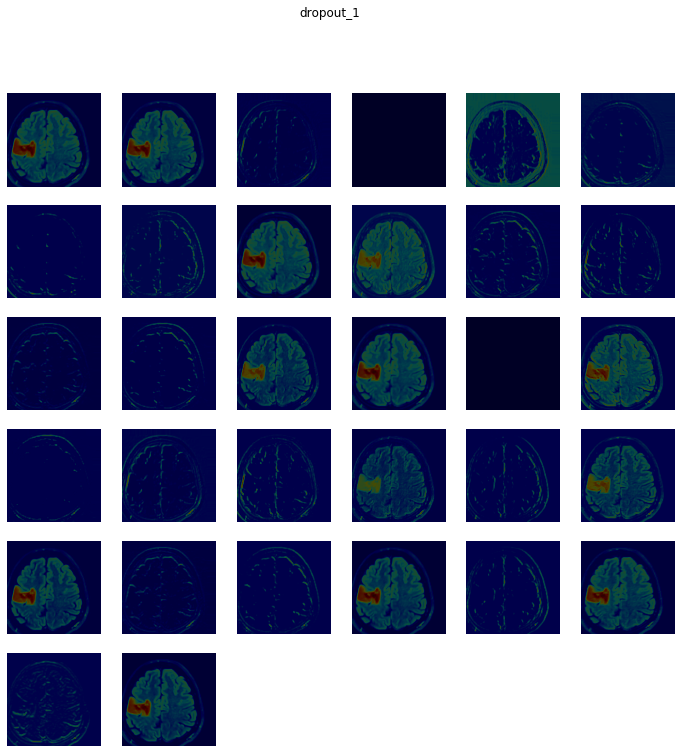

conv2d_6 (1, 125, 125, 64) 


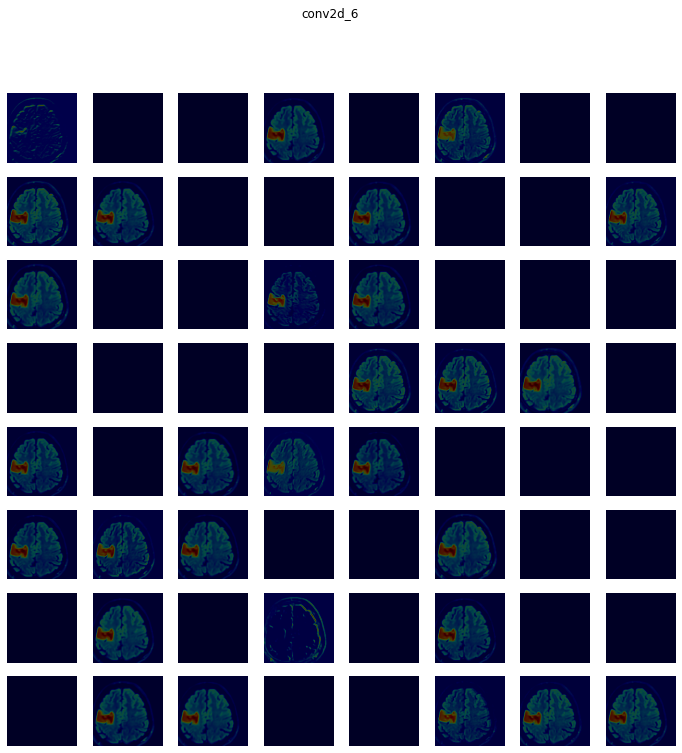

max_pooling2d_6 (1, 62, 62, 64) 


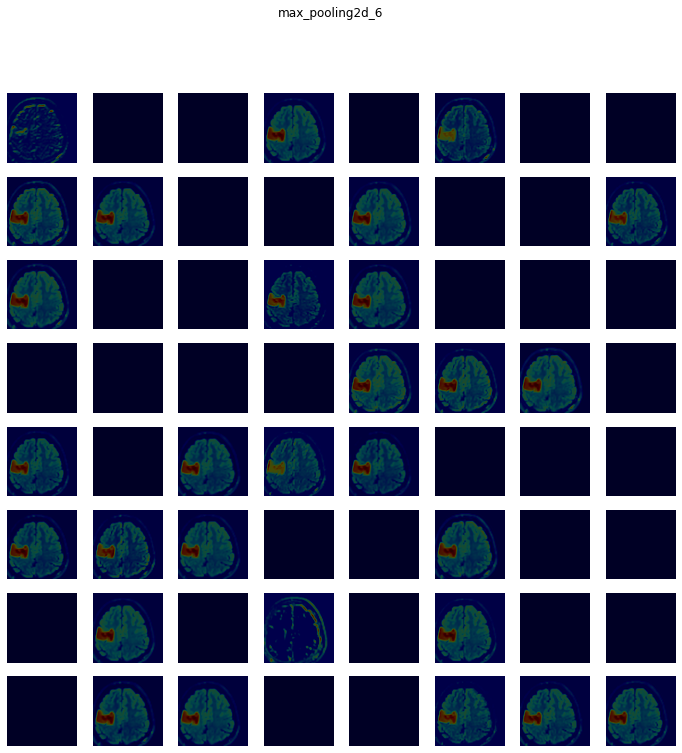

dropout_2 (1, 62, 62, 64) 


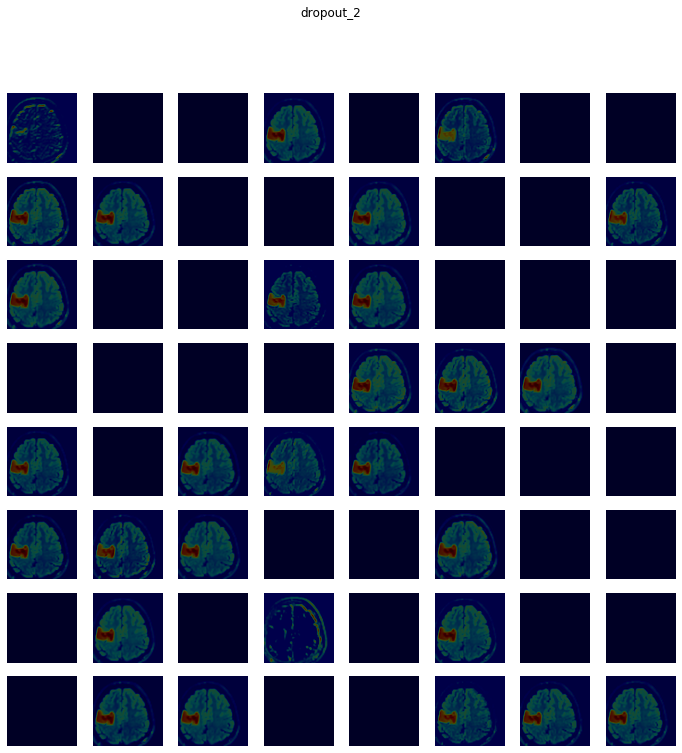

conv2d_7 (1, 60, 60, 128) 


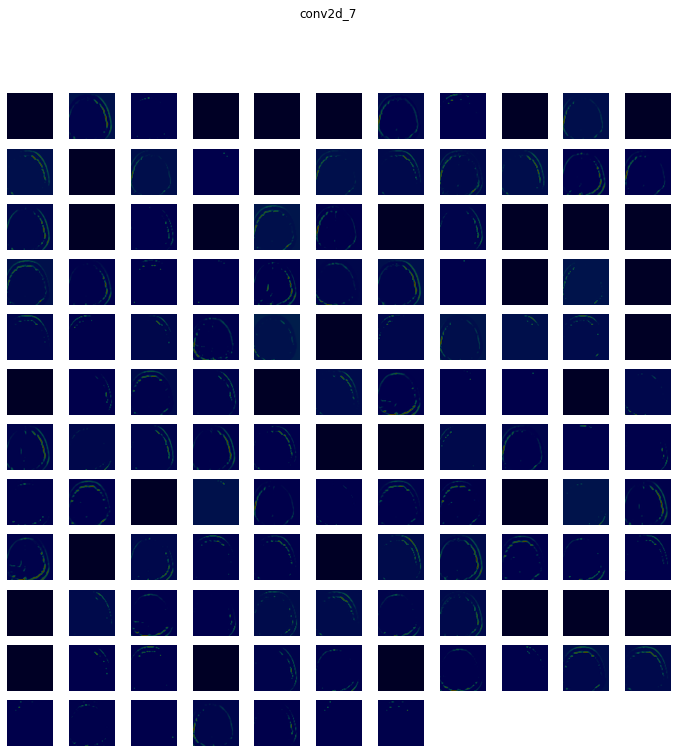

max_pooling2d_7 (1, 30, 30, 128) 


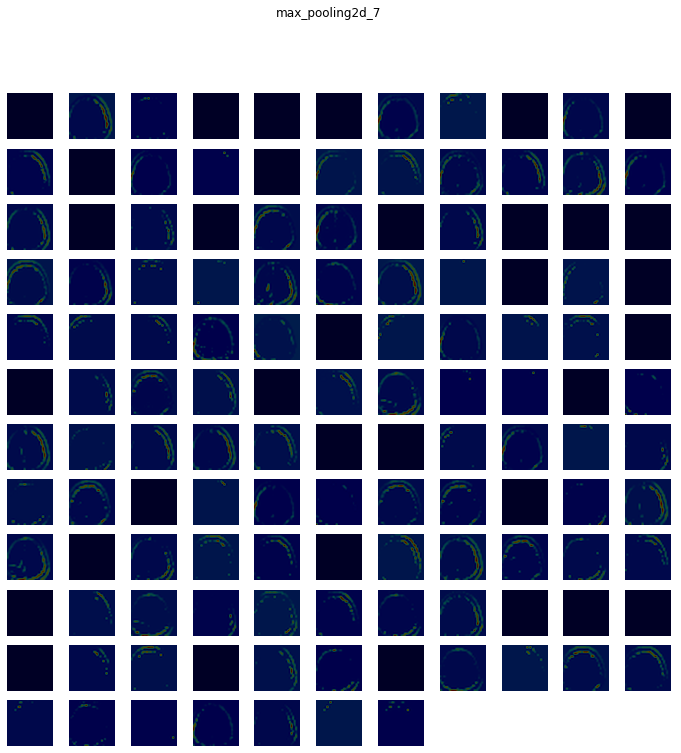

dropout_3 (1, 30, 30, 128) 


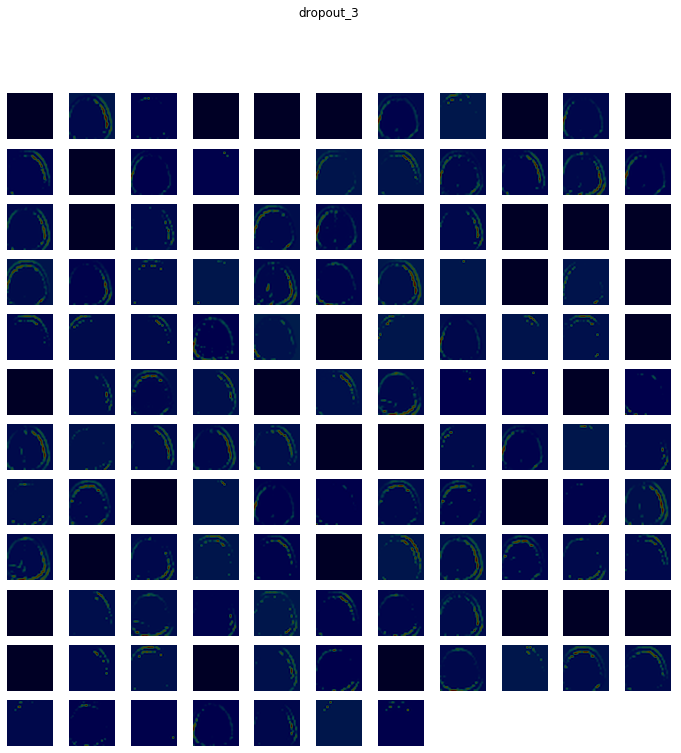

flatten_2 (1, 115200) -> Skipped. 2D Activations.
dense_3 (1, 64) -> Skipped. 2D Activations.
dense_4 (1, 1) -> Skipped. 2D Activations.


In [22]:
import numpy as np
from keras import Input, Model
from keras.layers import Dense, concatenate
from keract import get_activations, display_heatmaps
keract_inputs = X_test[:1]
keract_targets = y_test[:1]
activations = get_activations(classifier, keract_inputs)
display_heatmaps(activations, keract_inputs, save=False)

In [174]:
from keras import backend as K

inp = classifier.input                                           # input placeholder
outputs = [layer.output for layer in classifier.layers]          # all layer outputs
functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

# Testing
test = np.random.random(input_shape)[np.newaxis,...]
layer_outs = [func([test, 1.]) for func in functors]
print(layer_outs)

NameError: name 'input_shape' is not defined

In [42]:
import numpy as np
from keras.preprocessing import image
# test_image = image.load_img('C://Users//anvit//OneDrive//Desktop//Project_1//brain_tumor_dataset//yes_aug__0_413', target_size = (256, 256))
test_image = test[1]
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
print(result)
# print(training_set.class_indices)
if result[0][0] == 1:
    prediction = 'cancer'
else:
    prediction = 'no cancer'
print(prediction)

[[0.]]
no cancer


In [46]:
test = []
for image in yes_images:
    img = cv2.imread('C:/Users/anvit/OneDrive/Desktop/Project_1/brain_tumor_dataset/no_aug/' + image)
    face = cv2.resize(img, (256, 256))
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    test.append(face)

error: OpenCV(4.1.1) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [45]:
print(test[1])

IndexError: list index out of range

In [48]:
labels =["Yes",  # index 0
        "No",      # index 1
        ]

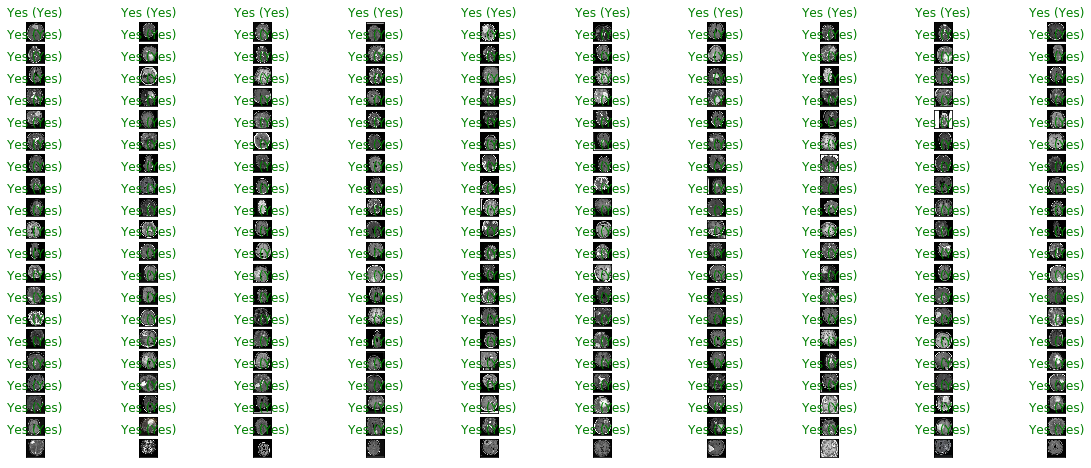

In [54]:
y_hat = classifier.predict(X_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=200, replace=False)):
    ax = figure.add_subplot(20,10, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()